In [ ]:

from google.colab import drive
drive.mount('/content/drive')


data_dir = "/content/drive/MyDrive/FYP/ser-selective-enhancement/data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# === File paths ===
clean_path = '/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_clean.csv'
noisy_path = '/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_noisy_10db.csv'
# === Load Data ===
clean_df = pd.read_csv(clean_path)
noisy_df = pd.read_csv(noisy_path)

# ✅ Fix: Only compare values, not indices
assert all(clean_df['LLD_Index'].values == noisy_df['LLD_Index'].values), "Mismatch in LLD indices"

# === Helper Functions ===
def get_performance_rank(df_noisy, emotion):
    ranked = df_noisy[['LLD_Index', emotion]].copy()
    ranked = ranked.sort_values(by=emotion, ascending=False).reset_index(drop=True)
    ranked['Performance_Rank'] = ranked.index
    return ranked
def get_robustness_rank(df_clean, df_noisy, emotion):
    drop_df = pd.DataFrame({
        'LLD_Index': df_clean['LLD_Index'],
        'Drop': (df_clean[emotion] - noisy_df[emotion]).abs()
    })
    drop_df = drop_df.sort_values(by='Drop', ascending=True).reset_index(drop=True)
    drop_df['Robustness_Rank'] = drop_df.index
    return drop_df
def merge_and_compute_joint_rank(perf_df, rob_df):
    merged = pd.merge(perf_df, rob_df, on='LLD_Index')
    merged['Joint_Rank'] = merged['Performance_Rank'] + merged['Robustness_Rank']
    return merged.sort_values(by='Joint_Rank')

# === Main Loop for Arousal, Valence, Dominance ===
for emo in ['Arousal', 'Valence', 'Dominance']:
    perf_df = get_performance_rank(noisy_df, emo)
    rob_df = get_robustness_rank(clean_df, noisy_df, emo)
    ranked_df = merge_and_compute_joint_rank(perf_df, rob_df)

    # Save to CSV
    output_path = f'/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/joint_rank_{emo.lower()}.csv'
    ranked_df.to_csv(output_path, index=False)
    print(f"✅ Saved joint_rank_{emo.lower()}.csv with {len(ranked_df)} features")


✅ Saved joint_rank_arousal.csv with 65 features
✅ Saved joint_rank_valence.csv with 65 features
✅ Saved joint_rank_dominance.csv with 65 features


In [ ]:
import pandas as pd

# Load individual rankings
arousal_rank = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/joint_rank_arousal.csv')
valence_rank = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/joint_rank_valence.csv')
dominance_rank = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/joint_rank_dominance.csv')


In [ ]:
# Merge by LLD_Index
merged = arousal_rank[['LLD_Index', 'Joint_Rank']].rename(columns={'Joint_Rank': 'Arousal_Rank'})
merged = pd.merge(merged, valence_rank[['LLD_Index', 'Joint_Rank']].rename(columns={'Joint_Rank': 'Valence_Rank'}), on='LLD_Index')
merged = pd.merge(merged, dominance_rank[['LLD_Index', 'Joint_Rank']].rename(columns={'Joint_Rank': 'Dominance_Rank'}), on='LLD_Index')

# Compute average joint rank
merged['Average_Rank'] = merged[['Arousal_Rank', 'Valence_Rank', 'Dominance_Rank']].mean(axis=1)
merged = merged.sort_values(by='Average_Rank')


In [ ]:
num_features = len(merged)
weak_cutoff = int(num_features * 0.3)

weak_features = merged.head(weak_cutoff)['LLD_Index'].tolist()
robust_features = merged.tail(num_features - weak_cutoff)['LLD_Index'].tolist()


In [ ]:
# Save to files
import json

with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/weak_features.json', 'w') as f:
    json.dump(weak_features, f)

with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/robust_features.json', 'w') as f:
    json.dump(robust_features, f)

print(f"✅ Saved {len(weak_features)} weak and {len(robust_features)} robust features.")


✅ Saved 19 weak and 46 robust features.


In [ ]:
pip install torch numpy pandas scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import json

with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/weak_features.json', 'r') as f:
    weak_features = json.load(f)


In [ ]:
import torch
import torch.nn as nn

class FeatureGenerator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.gru = nn.GRU(input_dim, 512, 4, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(1024, input_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.linear(out) + x  # Residual connection

class FeatureDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.gru = nn.GRU(input_dim, 32, 3, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return torch.sigmoid(self.fc(out[:, -1]))  # Output one score per sequence


In [ ]:
import os
import pandas as pd
import numpy as np
import torch

torch.backends.cudnn.benchmark = True

def load_lld_pairs(clean_dir, noisy_dir, lld_index, labels_df, max_len=100):
    X_clean, X_noisy = [], []

    noisy_files = [f for f in os.listdir(noisy_dir) if f.endswith('.csv')]

    for noisy_file in noisy_files:
        # Remove "_10db" from noisy file name
        base_name = noisy_file.replace('_10db', '')

        clean_file = base_name  # e.g., 1091_WSI_HAP_XX.csv
        noisy_path = os.path.join(noisy_dir, noisy_file)
        clean_path = os.path.join(clean_dir, clean_file)

        if not os.path.exists(clean_path):
            print(f"❌ Missing clean file for {noisy_file}")
            continue

        if not labels_df['filename'].str.contains(clean_file.replace('.csv', '.wav')).any():
            continue

        try:
            df_clean = pd.read_csv(clean_path, sep=';', comment='@')
            df_noisy = pd.read_csv(noisy_path, sep=';', comment='@')
        except Exception as e:
            print(f"⚠️ Error reading {clean_file} or {noisy_file}: {e}")
            continue

        if df_clean.shape[1] <= lld_index or df_noisy.shape[1] <= lld_index:
            print(f"⛔ LLD {lld_index} not available in {clean_file}")
            continue

        c_series = df_clean.iloc[:, lld_index].values[:max_len]
        n_series = df_noisy.iloc[:, lld_index].values[:max_len]

        c_series = np.pad(c_series, (0, max(0, max_len - len(c_series))))
        n_series = np.pad(n_series, (0, max(0, max_len - len(n_series))))

        X_clean.append(c_series)
        X_noisy.append(n_series)

    if len(X_clean) == 0:
        return None, None

    X_clean = torch.tensor(np.array(X_clean), dtype=torch.float32).unsqueeze(-1)
    X_noisy = torch.tensor(np.array(X_noisy), dtype=torch.float32).unsqueeze(-1)


    return X_clean, X_noisy


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
def train_gan_for_lld(X_noisy, X_clean, lld_index, save_path, epochs=100, batch_size=256):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    G = FeatureGenerator(1).to(device)
    D = FeatureDiscriminator(1).to(device)
    mse = nn.MSELoss()
    bce = nn.BCELoss()
    opt_g = torch.optim.Adam(G.parameters(), lr=1e-4)
    opt_d = torch.optim.Adam(D.parameters(), lr=1e-4)
    dataset = TensorDataset(X_noisy, X_clean)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    for epoch in range(epochs):
        G.train()
        D.train()
        for noisy_batch, clean_batch in loader:
            noisy_batch = noisy_batch.to(device)
            clean_batch = clean_batch.to(device)
            # --- Discriminator ---
            D_real = D(clean_batch)
            D_fake = D(G(noisy_batch).detach())
            loss_d = 0.5 * (bce(D_real, torch.ones_like(D_real)) +
                            bce(D_fake, torch.zeros_like(D_fake)))
            opt_d.zero_grad()
            loss_d.backward()
            opt_d.step()
            # --- Generator (10x more often as in paper) ---
            for _ in range(10):
                fake = G(noisy_batch)
                D_fake = D(fake)
                loss_g = 0.5 * bce(D_fake, torch.ones_like(D_fake)) + mse(fake, clean_batch)
                opt_g.zero_grad()
                loss_g.backward()
                opt_g.step()
            print(f"Epoch {epoch}: G Loss = {loss_g.item():.4f}, D Loss = {loss_d.item():.4f}")
    # Save Generator
    torch.save(G.state_dict(), os.path.join(save_path, f'G_lld_{lld_index}.pt'))
    print(f"✅ Trained and saved G for LLD {lld_index}")

In [ ]:
labels_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/data/labels.csv')
clean_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/clean_lld'
noisy_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/noisy_10db_lld'
save_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/models/generators'

os.makedirs(save_dir, exist_ok=True)

for lld_idx in weak_features:
    model_path = os.path.join(save_dir, f'G_lld_{lld_idx}.pt')

    if os.path.exists(model_path):
        print(f"✅ Skipping LLD {lld_idx} (already trained)")
        continue

    print(f"\n--- Training GAN for LLD {lld_idx} ---")
    X_clean, X_noisy = load_lld_pairs(clean_dir, noisy_dir, lld_idx, labels_df)
    if len(X_clean) == 0:
        print(f"⚠️ Skipping LLD {lld_idx} (no data)")
        continue
    train_gan_for_lld(X_noisy, X_clean, lld_idx, save_path=save_dir)


✅ Skipping LLD 62 (already trained)
✅ Skipping LLD 1 (already trained)
✅ Skipping LLD 7 (already trained)
✅ Skipping LLD 37 (already trained)
✅ Skipping LLD 41 (already trained)
✅ Skipping LLD 26 (already trained)
✅ Skipping LLD 57 (already trained)
✅ Skipping LLD 24 (already trained)
✅ Skipping LLD 52 (already trained)
✅ Skipping LLD 28 (already trained)
✅ Skipping LLD 8 (already trained)
✅ Skipping LLD 40 (already trained)

--- Training GAN for LLD 47 ---
[LLD 47] Epoch 1/100 | G Loss: 0.5128 | D Loss: 0.6932
[LLD 47] Epoch 2/100 | G Loss: 0.7020 | D Loss: 0.6932
[LLD 47] Epoch 3/100 | G Loss: 0.6251 | D Loss: 0.6931
[LLD 47] Epoch 4/100 | G Loss: 0.6484 | D Loss: 0.6931
[LLD 47] Epoch 5/100 | G Loss: 0.7426 | D Loss: 0.6932
[LLD 47] Epoch 6/100 | G Loss: 0.6593 | D Loss: 0.6931
[LLD 47] Epoch 7/100 | G Loss: 0.7025 | D Loss: 0.6931


In [ ]:
import json

with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/weak_features.json') as f:
    weak_features = json.load(f)

with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/robust_features.json') as f:
    robust_features = json.load(f)


In [1]:
import torch

# Define the device globally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_generators(weak_features, model_dir):
    G_dict = {}
    for lld_idx in weak_features:
        G = FeatureGenerator(1).to(device)  # Move model to GPU
        G.load_state_dict(torch.load(f"{model_dir}/G_lld_{lld_idx}.pt", map_location=device))
        G.eval()
        G_dict[lld_idx] = G
    return G_dict

# Load models with GPU enabled
G_dict = load_generators(weak_features, '/content/drive/MyDrive/FYP/ser-selective-enhancement/models/generators')



NameError: name 'weak_features' is not defined

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

def enhance_features_for_all(noisy_dir, output_dir, G_dict, weak_features, robust_features):
    os.makedirs(output_dir, exist_ok=True)
    files = [f for f in os.listdir(noisy_dir) if f.endswith('.csv')]

    for file in tqdm(files, desc="Enhancing features"):
        fpath = os.path.join(noisy_dir, file)
        try:
            df = pd.read_csv(fpath, sep=';', comment='@')
        except:
            continue

        all_features = []

        for i in range(65):
            series = pd.to_numeric(df.iloc[:, i], errors='coerce').fillna(0).values[:100]
            series = np.pad(series, (0, max(0, 100 - len(series))), mode='constant')
            tensor = torch.tensor(series, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)    # (1, 100, 1)

            if i in weak_features:
                enhanced = G_dict[i](tensor).squeeze().detach().cpu().numpy()
            else:
                enhanced = series  # keep robust feature raw

            all_features.append(enhanced)

        all_features = np.stack(all_features, axis=-1)  # (100, 65)
        out_df = pd.DataFrame(all_features, columns=[f'LLD_{i}' for i in range(65)])
        out_df.to_csv(os.path.join(output_dir, file), index=False)

    print(f"✅ All enhanced features saved to: {output_dir}")


In [ ]:
import json

# Load feature sets
with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/weak_features.json') as f:
    weak_features = json.load(f)

with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/robust_features.json') as f:
    robust_features = json.load(f)

# Set input/output dirs
noisy_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/noisy_10db_lld'
output_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced'

# Run enhancement
enhance_features_for_all(noisy_dir, output_dir, G_dict, weak_features, robust_features)


Enhancing features: 100%|██████████| 7315/7315 [55:51<00:00,  2.18it/s]

✅ All enhanced features saved to: /content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced


In [ ]:
import os

# Define your folders
input_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/noisy_5db_lld'
output_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced'

# Count total .csv files
total_files = len([f for f in os.listdir(input_dir) if f.endswith('.csv')])
enhanced_files = len([f for f in os.listdir(output_dir) if f.endswith('.csv')])

# Calculate percentage
if total_files > 0:
    progress = (enhanced_files / total_files) * 100
    print(f"✅ Enhancement Progress: {enhanced_files}/{total_files} files processed ({progress:.2f}%)")
else:
    print("⚠️ No input files found.")


✅ Enhancement Progress: 7315/7340 files processed (99.66%)


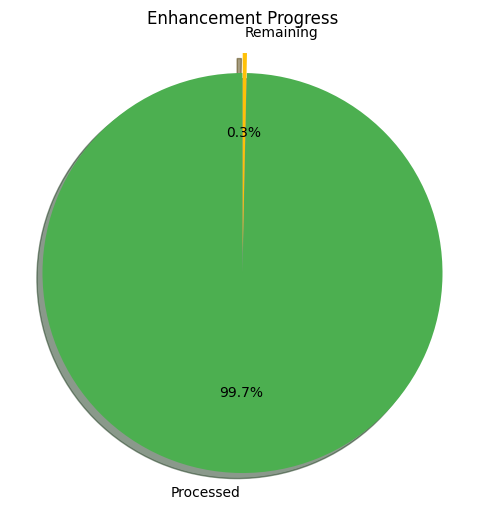

In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ['Processed', 'Remaining']
sizes = [enhanced_files, total_files - enhanced_files]
colors = ['#4CAF50', '#FFC107']  # Green, Yellow
explode = (0.1, 0)  # explode 1st slice

# Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Enhancement Progress')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()


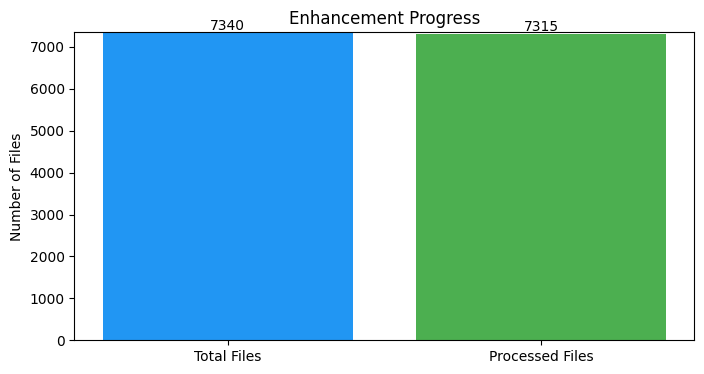

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Total Files', 'Processed Files']
values = [total_files, enhanced_files]
colors = ['#2196F3', '#4CAF50']

# Bar Chart
plt.figure(figsize=(8, 4))
plt.bar(categories, values, color=colors)
plt.title('Enhancement Progress')
plt.ylabel('Number of Files')

# Annotate bars with values
for i, v in enumerate(values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.ylim(0, max(total_files, enhanced_files) + 10)
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# === CONFIG ===
feature_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced'
labels_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/data/labels.csv')

X = []
y = []

# === LOAD only 100 files ===
count = 0
for file in labels_df['filename']:
    feature_path = f"{feature_dir}/{file.replace('.wav', '_10db.csv')}"
    if not os.path.exists(feature_path):
        continue
    try:
        df = pd.read_csv(feature_path)
        features = df.values[:100]
        if features.shape[0] < 100:
            features = np.pad(features, ((0, 100 - features.shape[0]), (0, 0)))
        X.append(features)
        y.append(labels_df[labels_df['filename'] == file]['emotion'].values[0])
        count += 1
        if count >= 100:
            break
    except:
        continue

X = np.array(X)
y = np.array(y)

# === Preprocess ===
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X.shape[2])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X.shape[2])).reshape(X_test.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# === Model ===
class SERClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(X.shape[2], 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear(128 * 50, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, features, time)
        return self.net(x)

model = SERClassifier(num_classes=len(np.unique(y_encoded))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# === Train for few epochs ===
for epoch in range(50):  # quick test
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# === Evaluate ===
model.eval()
with torch.no_grad():
    preds = model(X_test)
    predicted = preds.argmax(dim=1)
    acc = accuracy_score(y_test.cpu(), predicted.cpu()) * 100
    print(f"\n✅ Mini Test Accuracy (on {len(X)} samples): {acc:.2f}%")


Epoch 1: Loss = 1.8048
Epoch 2: Loss = 1.7881
Epoch 3: Loss = 1.7742
Epoch 4: Loss = 1.7629
Epoch 5: Loss = 1.7538
Epoch 6: Loss = 1.7453
Epoch 7: Loss = 1.7379
Epoch 8: Loss = 1.7310
Epoch 9: Loss = 1.7243
Epoch 10: Loss = 1.7178
Epoch 11: Loss = 1.7119
Epoch 12: Loss = 1.7061
Epoch 13: Loss = 1.7007
Epoch 14: Loss = 1.6952
Epoch 15: Loss = 1.6897
Epoch 16: Loss = 1.6842
Epoch 17: Loss = 1.6786
Epoch 18: Loss = 1.6731
Epoch 19: Loss = 1.6676
Epoch 20: Loss = 1.6621
Epoch 21: Loss = 1.6566
Epoch 22: Loss = 1.6509
Epoch 23: Loss = 1.6452
Epoch 24: Loss = 1.6395
Epoch 25: Loss = 1.6337
Epoch 26: Loss = 1.6277
Epoch 27: Loss = 1.6217
Epoch 28: Loss = 1.6157
Epoch 29: Loss = 1.6098
Epoch 30: Loss = 1.6037
Epoch 31: Loss = 1.5976
Epoch 32: Loss = 1.5914
Epoch 33: Loss = 1.5851
Epoch 34: Loss = 1.5787
Epoch 35: Loss = 1.5720
Epoch 36: Loss = 1.5651
Epoch 37: Loss = 1.5582
Epoch 38: Loss = 1.5512
Epoch 39: Loss = 1.5442
Epoch 40: Loss = 1.5371
Epoch 41: Loss = 1.5299
Epoch 42: Loss = 1.5227
E

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# === CONFIG ===
feature_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced'
labels_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/data/labels.csv')

X = []
y = []

# === LOAD only 100 files ===
count = 0
for file in labels_df['filename']:
    feature_path = f"{feature_dir}/{file.replace('.wav', '_10db.csv')}"
    if not os.path.exists(feature_path):
        continue
    try:
        df = pd.read_csv(feature_path)
        features = df.values[:100]
        if features.shape[0] < 100:
            features = np.pad(features, ((0, 100 - features.shape[0]), (0, 0)))
        X.append(features)
        y.append(labels_df[labels_df['filename'] == file]['emotion'].values[0])
        count += 1
        if count >= 100:
            break
    except:
        continue

X = np.array(X)
y = np.array(y)

# === Preprocess ===
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X.shape[2])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X.shape[2])).reshape(X_test.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# === Model ===
class SERClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(X.shape[2], 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear(128 * 50, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, features, time)
        return self.net(x)

model = SERClassifier(num_classes=len(np.unique(y_encoded))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# === Train for few epochs ===
for epoch in range(200):  # quick test
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# === Evaluate ===
model.eval()
with torch.no_grad():
    preds = model(X_test)
    predicted = preds.argmax(dim=1)
    acc = accuracy_score(y_test.cpu(), predicted.cpu()) * 100
    print(f"\n✅ Mini Test Accuracy (on {len(X)} samples): {acc:.2f}%")


Epoch 1: Loss = 1.7842
Epoch 2: Loss = 1.7672
Epoch 3: Loss = 1.7545
Epoch 4: Loss = 1.7443
Epoch 5: Loss = 1.7360
Epoch 6: Loss = 1.7294
Epoch 7: Loss = 1.7233
Epoch 8: Loss = 1.7175
Epoch 9: Loss = 1.7118
Epoch 10: Loss = 1.7058
Epoch 11: Loss = 1.6998
Epoch 12: Loss = 1.6939
Epoch 13: Loss = 1.6881
Epoch 14: Loss = 1.6822
Epoch 15: Loss = 1.6765
Epoch 16: Loss = 1.6708
Epoch 17: Loss = 1.6650
Epoch 18: Loss = 1.6591
Epoch 19: Loss = 1.6532
Epoch 20: Loss = 1.6471
Epoch 21: Loss = 1.6410
Epoch 22: Loss = 1.6348
Epoch 23: Loss = 1.6286
Epoch 24: Loss = 1.6223
Epoch 25: Loss = 1.6160
Epoch 26: Loss = 1.6096
Epoch 27: Loss = 1.6031
Epoch 28: Loss = 1.5966
Epoch 29: Loss = 1.5901
Epoch 30: Loss = 1.5835
Epoch 31: Loss = 1.5770
Epoch 32: Loss = 1.5703
Epoch 33: Loss = 1.5635
Epoch 34: Loss = 1.5567
Epoch 35: Loss = 1.5498
Epoch 36: Loss = 1.5428
Epoch 37: Loss = 1.5358
Epoch 38: Loss = 1.5289
Epoch 39: Loss = 1.5219
Epoch 40: Loss = 1.5147
Epoch 41: Loss = 1.5076
Epoch 42: Loss = 1.5005
E

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# === CONFIG ===
feature_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced'
labels_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/data/labels.csv')

X = []
y = []

# === LOAD only 100 files ===
count = 0
for file in labels_df['filename']:
    feature_path = f"{feature_dir}/{file.replace('.wav', '_10db.csv')}"
    if not os.path.exists(feature_path):
        continue
    try:
        df = pd.read_csv(feature_path)
        features = df.values[:100]
        if features.shape[0] < 100:
            features = np.pad(features, ((0, 100 - features.shape[0]), (0, 0)))
        X.append(features)
        y.append(labels_df[labels_df['filename'] == file]['emotion'].values[0])
        count += 1
        if count >= 100:
            break
    except:
        continue

X = np.array(X)
y = np.array(y)

# === Preprocess ===
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X.shape[2])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X.shape[2])).reshape(X_test.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# === Model ===
class SERClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(X.shape[2], 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear(128 * 50, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, features, time)
        return self.net(x)

model = SERClassifier(num_classes=len(np.unique(y_encoded))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# === Train for few epochs ===
for epoch in range(300):  # quick test
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# === Evaluate ===
model.eval()
with torch.no_grad():
    preds = model(X_test)
    predicted = preds.argmax(dim=1)
    acc = accuracy_score(y_test.cpu(), predicted.cpu()) * 100
    print(f"\n✅ Mini Test Accuracy (on {len(X)} samples): {acc:.2f}%")


Epoch 1: Loss = 1.7934
Epoch 2: Loss = 1.7788
Epoch 3: Loss = 1.7664
Epoch 4: Loss = 1.7560
Epoch 5: Loss = 1.7469
Epoch 6: Loss = 1.7394
Epoch 7: Loss = 1.7323
Epoch 8: Loss = 1.7258
Epoch 9: Loss = 1.7195
Epoch 10: Loss = 1.7132
Epoch 11: Loss = 1.7068
Epoch 12: Loss = 1.7004
Epoch 13: Loss = 1.6942
Epoch 14: Loss = 1.6884
Epoch 15: Loss = 1.6828
Epoch 16: Loss = 1.6771
Epoch 17: Loss = 1.6714
Epoch 18: Loss = 1.6656
Epoch 19: Loss = 1.6598
Epoch 20: Loss = 1.6540
Epoch 21: Loss = 1.6481
Epoch 22: Loss = 1.6421
Epoch 23: Loss = 1.6361
Epoch 24: Loss = 1.6300
Epoch 25: Loss = 1.6239
Epoch 26: Loss = 1.6176
Epoch 27: Loss = 1.6112
Epoch 28: Loss = 1.6047
Epoch 29: Loss = 1.5981
Epoch 30: Loss = 1.5913
Epoch 31: Loss = 1.5845
Epoch 32: Loss = 1.5776
Epoch 33: Loss = 1.5707
Epoch 34: Loss = 1.5636
Epoch 35: Loss = 1.5563
Epoch 36: Loss = 1.5490
Epoch 37: Loss = 1.5417
Epoch 38: Loss = 1.5345
Epoch 39: Loss = 1.5272
Epoch 40: Loss = 1.5199
Epoch 41: Loss = 1.5124
Epoch 42: Loss = 1.5050
E

In [ ]:
from collections import Counter
print("Class distribution in Y:", Counter(y))


Class distribution in Y: Counter({np.str_('sad'): 19, np.str_('fearful'): 18, np.str_('happy'): 18, np.str_('angry'): 17, np.str_('disgust'): 17, np.str_('neutral'): 11})


In [ ]:
print(file)
print(labels_df[labels_df['filename'] == file])


1001_IEO_FEA_MD.wav
               filename  emotion  arousal  valence  dominance
99  1001_IEO_FEA_MD.wav  fearful      0.9     -0.8        0.3


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# === CONFIG ===
feature_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced'
labels_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/data/labels.csv')

X = []
y = []

# === Load ALL available files with augmentation ===

def augment_features(features, noise_level=0.01):
    noise = np.random.normal(0, noise_level, features.shape)
    return features + noise

for file in labels_df['filename']:
    feature_path = f"{feature_dir}/{file.replace('.wav', '_10db.csv')}"
    if not os.path.exists(feature_path):
        continue
    try:
        df = pd.read_csv(feature_path)
        features = df.values[:100]
        if features.shape[0] < 100:
            features = np.pad(features, ((0, 100 - features.shape[0]), (0, 0)))
        # original
        X.append(features)
        y.append(labels_df[labels_df['filename'] == file]['emotion'].values[0])
        # augmented versions
        for _ in range(2):  # create 2 augmented samples per original
            aug_feat = augment_features(features)
            X.append(aug_feat)
            y.append(labels_df[labels_df['filename'] == file]['emotion'].values[0])
    except Exception as e:
        print(f"Error loading {file}: {e}")
        continue

X = np.array(X)
y = np.array(y)

print(f"Total samples after augmentation: {len(X)}")

# === Preprocess ===
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split into train + val + test (70% train, 15% val, 15% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val)  # 0.1765*0.85 ~ 0.15 overall val size

print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")

# Normalize per feature over all train samples and time steps
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X.shape[2])
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train = X_train_scaled.reshape(X_train.shape)

X_val_reshaped = X_val.reshape(-1, X.shape[2])
X_val_scaled = scaler.transform(X_val_reshaped)
X_val = X_val_scaled.reshape(X_val.shape)

X_test_reshaped = X_test.reshape(-1, X.shape[2])
X_test_scaled = scaler.transform(X_test_reshaped)
X_test = X_test_scaled.reshape(X_test.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# === Improved Model ===
class SERClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(X.shape[2], 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128 * 25, 64),  # 100/2/2 = 25 time steps after pooling
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, features, time)
        return self.net(x)

model = SERClassifier(num_classes=len(np.unique(y_encoded))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# === Training with Early Stopping ===
best_val_loss = float('inf')
patience = 20
trigger_times = 0

for epoch in range(300):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

    # Early stopping
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        trigger_times = 0
        torch.save(model.state_dict(), 'best_ser_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

# === Load best model and Evaluate on test set ===
model.load_state_dict(torch.load('best_ser_model.pth'))
model.eval()
with torch.no_grad():
    preds = model(X_test)
    predicted = preds.argmax(dim=1)
    acc = accuracy_score(y_test.cpu(), predicted.cpu()) * 100
    print(f"\n✅ Test Accuracy (on {len(X_test)} samples): {acc:.2f}%")


Total samples after augmentation: 21945
Train samples: 15360, Val samples: 3293, Test samples: 3292
Epoch 1: Train Loss = 1.7951, Val Loss = 1.7844
Epoch 2: Train Loss = 1.7895, Val Loss = 1.7815
Epoch 3: Train Loss = 1.7853, Val Loss = 1.7790
Epoch 4: Train Loss = 1.7814, Val Loss = 1.7766
Epoch 5: Train Loss = 1.7789, Val Loss = 1.7740
Epoch 6: Train Loss = 1.7774, Val Loss = 1.7715
Epoch 7: Train Loss = 1.7736, Val Loss = 1.7689
Epoch 8: Train Loss = 1.7706, Val Loss = 1.7664
Epoch 9: Train Loss = 1.7675, Val Loss = 1.7638
Epoch 10: Train Loss = 1.7644, Val Loss = 1.7611
Epoch 11: Train Loss = 1.7627, Val Loss = 1.7582
Epoch 12: Train Loss = 1.7595, Val Loss = 1.7551
Epoch 13: Train Loss = 1.7561, Val Loss = 1.7519
Epoch 14: Train Loss = 1.7524, Val Loss = 1.7485
Epoch 15: Train Loss = 1.7502, Val Loss = 1.7450
Epoch 16: Train Loss = 1.7462, Val Loss = 1.7415
Epoch 17: Train Loss = 1.7436, Val Loss = 1.7378
Epoch 18: Train Loss = 1.7392, Val Loss = 1.7340
Epoch 19: Train Loss = 1.73

In [ ]:
import json

with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/weak_features.json') as f:
    weak_features = json.load(f)

with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/robust_features.json') as f:
    robust_features = json.load(f)


In [ ]:
import torch
import torch.nn as nn

# ✅ Define the Generator class
class FeatureGenerator(nn.Module):
    def __init__(self, input_dim):
        super(FeatureGenerator, self).__init__()
        self.gru = nn.GRU(input_dim, 512, 4, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(1024, input_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.linear(out) + x  # Residual connection

# ✅ Force use of CPU
device = torch.device("cpu")

# ✅ Load generators on CPU
def load_generators(weak_features, model_dir):
    G_dict = {}
    for lld_idx in weak_features:
        G = FeatureGenerator(1)  # CPU only
        G.load_state_dict(torch.load(f"{model_dir}/G_lld_{lld_idx}.pt", map_location=device))
        G.eval()
        G_dict[lld_idx] = G
    return G_dict

# ✅ Load weak features JSON if not already loaded
import json
with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/weak_features.json') as f:
    weak_features = json.load(f)

# ✅ Load generators into G_dict (CPU)
G_dict = load_generators(weak_features, '/content/drive/MyDrive/FYP/ser-selective-enhancement/models/generators')


In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

def enhance_features_for_all(noisy_dir, output_dir, G_dict, weak_features, robust_features):
    os.makedirs(output_dir, exist_ok=True)
    files = [f for f in os.listdir(noisy_dir) if f.endswith('.csv')]

    for file in tqdm(files, desc="Enhancing features"):
        fpath = os.path.join(noisy_dir, file)
        try:
            df = pd.read_csv(fpath, sep=';', comment='@')
        except:
            continue

        all_features = []

        for i in range(65):
            series = pd.to_numeric(df.iloc[:, i], errors='coerce').fillna(0).values[:100]
            series = np.pad(series, (0, max(0, 100 - len(series))), mode='constant')
            tensor = torch.tensor(series, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)    # (1, 100, 1)

            if i in weak_features:
                enhanced = G_dict[i](tensor).squeeze().detach().cpu().numpy()
            else:
                enhanced = series  # keep robust feature raw

            all_features.append(enhanced)

        all_features = np.stack(all_features, axis=-1)  # (100, 65)
        out_df = pd.DataFrame(all_features, columns=[f'LLD_{i}' for i in range(65)])
        out_df.to_csv(os.path.join(output_dir, file), index=False)

    print(f"✅ All enhanced features saved to: {output_dir}")


In [ ]:
import json

# Load feature sets
with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/weak_features.json') as f:
    weak_features = json.load(f)

with open('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/robust_features.json') as f:
    robust_features = json.load(f)

# Set input/output dirs
noisy_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/noisy_5db_lld'
output_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced_5db'

# Run enhancement
enhance_features_for_all(noisy_dir, output_dir, G_dict, weak_features, robust_features)


Enhancing features:   1%|          | 66/7340 [06:40<12:15:26,  6.07s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-13-3264625273.py", line 15, in <cell line: 0>
    enhance_features_for_all(noisy_dir, output_dir, G_dict, weak_features, robust_features)
  File "/tmp/ipython-input-12-4081489122.py", line 25, in enhance_features_for_all
    enhanced = G_dict[i](tensor).squeeze().detach().cpu().numpy()
               ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-11-3616588733.py", line 12, in forward
    out, _

TypeError: object of type 'NoneType' has no len()